
[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Get:1 http://deb.debian.org/debian buster InRelease [122 kB]
Get:2 http://deb.debian.org/debian-security buster/updates InRelease [34.8 kB]
Get:3 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]
Get:4 http://deb.debian.org/debian buster/main amd64 Packages [7,909 kB]
Get:5 http://deb.debian.org/debian-security buster/updates/main amd64 Packages [610 kB]
Get:6 http://deb.debian.org/debian buster-updates/main amd64 Packages [8,788 B]
Fetched 8,741 kB in 2s (4,740 kB/s)
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libdrm2 libgl1 libgl1-mesa-dri libglapi-mesa libg

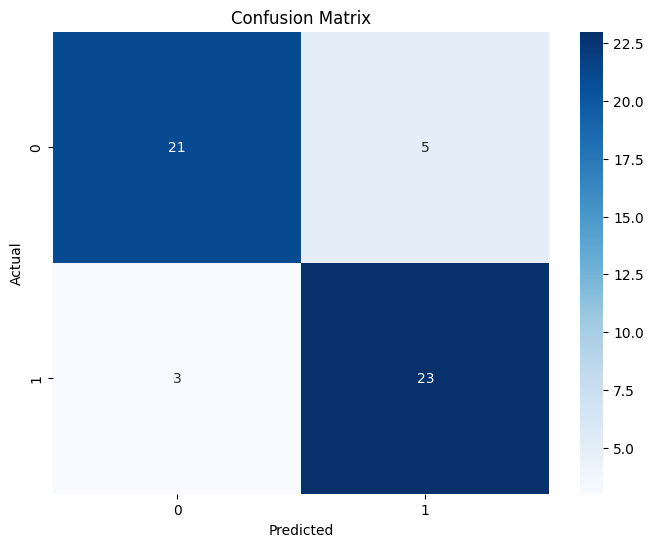

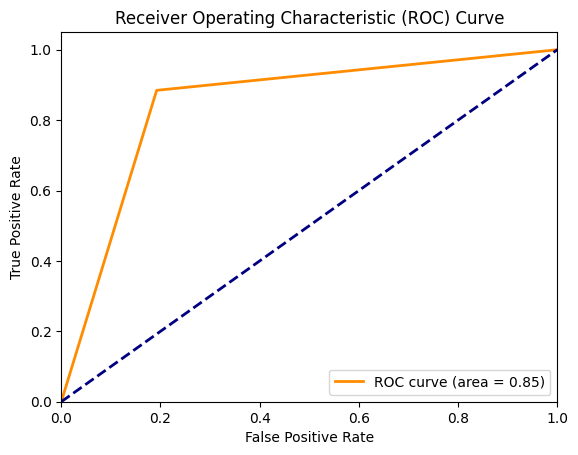

False Positives (Image IDs): ['TU1R_133', 'TU2R_41', 'TU1R_118', 'TU2R_304', 'TU1L_134']
False Negatives (Image IDs): ['TU1L_173', 'TU1R_195', 'TU2R_91']


In [1]:
"""
This script is intended for training a Support Vector Machine (SVM) model for ultrasonic-image classification tasks.
The process involves data loading, preprocessing, model training with hyperparameter optimization, evaluation,
and results visualization. It utilizes several Python libraries including scikit-learn, xgboost, joblib, seaborn, 
pandas, and matplotlib.

Authors:
- Quỳnh Anh Nguyễn
- Heyi Wang

Functions:
main(): Coordinates the entire process, including data loading, model training, and evaluation.
load_data(): Loads the training and testing datasets.
preprocess_data(X): Performs data scaling using MinMaxScaler.
train_model(X_train, y_train): Conducts hyperparameter tuning using GridSearchCV to find the best SVM model.
evaluate_model(model, X_test, y_test): Evaluates the trained model on the test dataset.

Requirements:
Python 3.x
Libraries: scikit-learn, xgboost, joblib, seaborn, pandas, matplotlib, opencv-python
"""

#Install all the packages
"""
Import necessary libraries for data manipulation and machine learning
"""
!pip install scikit-learn xgboost joblib seaborn pandas matplotlib
!pip install opencv-python
# Install the required library
os.system('apt-get update')
os.system('apt-get install -y libgl1-mesa-glx')
import pandas as pd
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, f1_score
import joblib
from sklearn.metrics import confusion_matrix
import cv2
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score, roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Import train feature table. Path must be changed before use
reference = pd.read_csv('/work/Train/features_train.csv')
# Remore Image_ID columns
reference.drop('Image_ID', axis='columns', inplace=True)
reference

# Create training data
X_train = reference.iloc [:, 1:]
y_train = reference.iloc [:, 0]

# Initiate SVM model
model = SVC()

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

# Define SVM parameter. Perform Grid Search with some-times(it coule be changed at cv=) Cross Validation
param_grid = {
'C': [0.01, 0.1, 1, 10, 100, 1000],
'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
'gamma': ['scale', 'auto']
}

## Define F1 as scoring metrics
## Alternative: try accuray
f1_scorer = make_scorer(f1_score)

# Initialise Hyperparameter Tuning
grid_search = GridSearchCV(model, param_grid, scoring=f1_scorer, cv=20, verbose = 1, n_jobs = -1)
grid_search.fit (X_train, y_train)

# # Define accuracy as the scoring metric
# accuracy_scorer = make_scorer(accuracy_score)
# grid_search = GridSearchCV(model, param_grid, scoring=accuracy_scorer, cv=20, verbose=1, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# Find out best parameter
final_param = grid_search.best_params_
final_score = grid_search.best_score_
print (f"Final parameter: {final_param}")
print (f"Final score: {final_score}")

# Find out best model
final_model = grid_search.best_estimator_

# Save model 
joblib.dump (final_model, 'SVM_model.pkl')


## Evaluation##
#load feature matrix of test set
feature_test = pd.read_csv('/work/Train/features_test.csv')
image_ids = feature_test['Image_ID']  # Save Image_IDs for later use
feature_test.drop('Image_ID', axis='columns', inplace=True)

X_test = feature_test.iloc [:, 1:]
y_test = feature_test.iloc [:, 0]

# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)

# Create prediction
loaded_model = joblib.load('SVM_model.pkl')
y_pred = loaded_model.predict(X_test)

# Print accuracy and f1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score (y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred)  # Use the positive class probabilities
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Identify false positives and false negatives
false_positives = image_ids[(y_test == 0) & (y_pred == 1)]
false_negatives = image_ids[(y_test == 1) & (y_pred == 0)]

# Print the results
print(f"False Positives (Image IDs): {false_positives.tolist()}")
print(f"False Negatives (Image IDs): {false_negatives.tolist()}")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c653169c-5500-4533-bb41-bc6c969106aa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>